In [109]:
import importlib
import helper, consts
importlib.reload(consts)
importlib.reload(helper)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [78]:
def get_train_data(name):
    if ".csv" not in name: name += ".csv"
    path = "/Users/hoangchu/Downloads/Clinic/Clinic/data/cleaned_data/train_data/"
    return pd.read_csv(path + name)

def get_test_data():
    from os import listdir
    from os.path import isfile, join  
    
    path = "/Users/hoangchu/Downloads/Clinic/Clinic/data/cleaned_data/test_data/"
    test_files = [f for f in listdir(path) if isfile(join(path, f))]
    answers = list(map(lambda filename: pd.read_csv(path + filename), test_files))
    return answers

def transform_col(df, col_name: str, transform_func: 'Function') -> None:
    df.loc[:, col_name] = df[col_name].apply(transform_func); return
    
def filter_duplicatations(df, axis: int) -> 'DataFrame':
    use_df = df if axis == 0 else df.T
    answer_df = use_df.drop_duplicates()
    return answer_df if axis == 0 else answer_df.T

In [80]:
train_y, train_X = train_df[consts.RESPONSE_NAME], train_df.drop(consts.RESPONSE_NAME, inplace=False, axis=consts.COL)

test_ys = [test_df[consts.RESPONSE_NAME] for test_df in test_dfs]
test_Xs = [test_df.drop(consts.RESPONSE_NAME, inplace=False, axis=consts.COL) for test_df in test_dfs]

# Tree Classification for Feature Selection

In [81]:
class_weight = {-1:1,1:1.2}

In [82]:
model = helper.Model("DecisionTreeClassifier", hyperparam_dict = {"random_state": 0})
model.add_metric('correctness', lambda pred_y, actual_y: sum(pred_y == actual_y) / len(actual_y))

path = model.inner.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [83]:
ccp_alpha_options = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
train_scores = []; test_scores = []
for ccp_alpha in ccp_alpha_options:
    kwarg = {"random_state": 0, "class_weight": class_weight, "ccp_alpha": ccp_alpha}
    model = helper.Model("DecisionTreeClassifier", hyperparam_dict = kwarg)
    model.add_metric("accuracy", lambda x, y: np.sum([x[i] == y[i] for i in range(len(x))]) / len(x))
    model.train(train_df)
    
    model.test(train_df); train_scores.append(model.metric_output["accuracy"])
    model.test(test_dfs[0]); test_scores.append(model.metric_output["accuracy"])

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Features being used: ['eqid', 'wt', 'today', 'tmwam', 'dn3sttmwmd', 'dn1', 'dn4x1', 'cftorrrelstd_open_0', 'liqlog_open_0', 'llirpnxm_am_1', 'llirpnxm_dy_12to16', 'llirpnxm_dy_17to21', 'llirpnxm_dy_1to3', 'llirpnxm_dy_4to6', 'llirpnxm_dy_7to11', 'llirpnxm_lst15_0', 'llirpnxm_lsthrx15_0', 'llirpnxm_md_1', 'llirpnxm_nt_0', 'llirpnxm_nt_1', 'llirpnxm_nt_12to16', 'llirpnxm_nt_17to21', 'llirpnxm_nt_1to3', 'llirpnxm_nt_4to6', 'llirpnxm_nt_7to11', 'llirpnxm_pm_1', 'llirpnxm_toxhr_0', 'mocrelvol_open_1', 'mocrelvol_open_13to17', 'mocrelvol_open_18to22', 'mocrelvol_open_2to

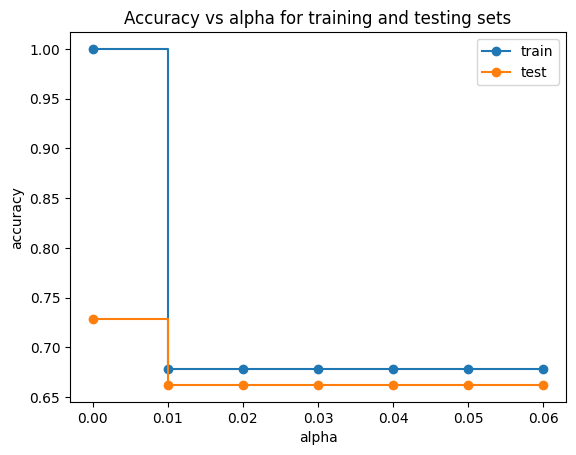

In [84]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alpha_options, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alpha_options, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [85]:
ALPHA = 0.01

In [86]:
kwarg = {"random_state": 0, "class_weight": class_weight, "ccp_alpha": ALPHA}
model = helper.Model("DecisionTreeClassifier", hyperparam_dict = kwarg)
model.add_metric("accuracy", lambda x, y: np.sum([x[i] == y[i] for i in range(len(x))]) / len(x))
model.train(train_df)

You're using: DecisionTreeClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Features being used: ['eqid', 'wt', 'today', 'tmwam', 'dn3sttmwmd', 'dn1', 'dn4x1', 'cftorrrelstd_open_0', 'liqlog_open_0', 'llirpnxm_am_1', 'llirpnxm_dy_12to16', 'llirpnxm_dy_17to21', 'llirpnxm_dy_1to3', 'llirpnxm_dy_4to6', 'llirpnxm_dy_7to11', 'llirpnxm_lst15_0', 'llirpnxm_lsthrx15_0', 'llirpnxm_md_1', 'llirpnxm_nt_0', 'llirpnxm_nt_1', 'llirpnxm_nt_12to16', 'llirpnxm_nt_17to21', 'llirpnxm_nt_1to3', 'llirpnxm_nt_4to6', 'llirpnxm_nt_7to11', 'llirpnxm_pm_1', 'llirpnxm_toxhr_0', 'mocrelvol_open_1', 'mocrelvol_open_13to17', 'mocrelvol_open_18to22', 'mocrelvol_open_2to

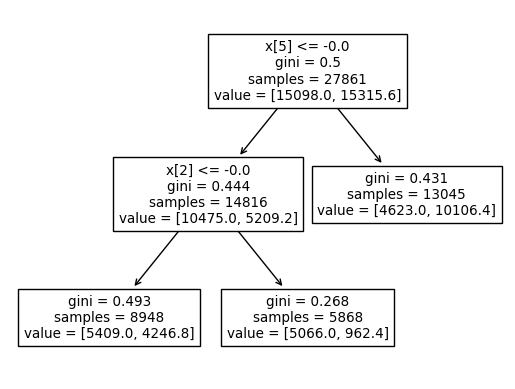

In [87]:
sklearn.tree.plot_tree(model.inner)
plt.show()

# Random Forest

In [88]:
from sklearn import ensemble

In [89]:
FILE_PATH = consts.PATH_MAP["HOANG"]
data = helper.Data(train_data_path=FILE_PATH)

In [90]:
train_dfs = data.update_and_get_train_df("20150121", backward_dayCount = 1, train_data_count = 100, concat = False)
for i, train_df in enumerate(train_dfs, start=0):
    train_df = filter_duplicatations(train_df, axis = consts.COL)
    transform_col(train_df, consts.RESPONSE_NAME, lambda x: 1 if x > 0 else -1)
    train_dfs[i] = train_df

Getting files from 2014-10-12 00:00:00 to 2015-01-20 00:00:00, inclusive.
Filtered File Dates: ['data.20150102_1200', 'data.20150105_1200', 'data.20150106_1200', 'data.20150107_1200', 'data.20150108_1200', 'data.20150109_1200', 'data.20150112_1200', 'data.20150113_1200', 'data.20150114_1200', 'data.20150115_1200', 'data.20150116_1200', 'data.20150120_1200']



In [91]:
feature_important_scores = np.array([0 for _ in range(len(model.inner.feature_importances_))])

In [92]:
for train_df in train_dfs:
    kwarg = {"random_state": 0, "bootstrap": False, "class_weight": class_weight, "ccp_alpha": ALPHA}
    rf_model = helper.Model("RandomForestClassifier", hyperparam_dict=kwarg)
    rf_model.train(train_df)
    for i in range(len(rf_model.inner.feature_importances_)):
        feature_important_scores[i] += rf_model.inner.feature_importances_[i]

You're using: RandomForestClassifier.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Features being used: ['eqid', 'wt', 'today', 'tmwam', 'dn3sttmwmd', 'dn1', 'dn4x1', 'cftorrrelstd_open_0', 'liqlog_open_0', 'llirpnxm_am_1', 'llirpnxm_dy_12to16', 'llirpnxm_dy_17to21', 'llirpnxm_dy_1to3', 'llirpnxm_dy_4to6', 'llirpnxm_dy_7to11', 'llirpnxm_lst15_0', 'llirpnxm_lsthrx15_0', 'llirpnxm_md_1', 'llirpnxm_nt_0', 'llirpnxm_nt_1', 'llirpnxm_nt_12to16', 'llirpnxm_nt_17to21', 'llirpnxm_nt_1to3', 'llirpnxm_nt_4to6', 'llirpnxm_nt_7to11', 'llirpnxm_pm

In [93]:
feature_important_scores

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [99]:
train_df = filter_duplicatations(data.update_and_get_train_df("20150121", backward_dayCount = 1, train_data_count = 100), axis = consts.COL)
xgb_model = helper.Model("XGBoost")
xgb_model.train(train_df)
xgb_model.test(test_dfs[0])

Getting files from 2014-10-12 00:00:00 to 2015-01-20 00:00:00, inclusive.
Filtered File Dates: ['data.20150102_1200', 'data.20150105_1200', 'data.20150106_1200', 'data.20150107_1200', 'data.20150108_1200', 'data.20150109_1200', 'data.20150112_1200', 'data.20150113_1200', 'data.20150114_1200', 'data.20150115_1200', 'data.20150116_1200', 'data.20150120_1200']

You're using: XGBOOST.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'ma

In [101]:
train_df = filter_duplicatations(data.update_and_get_train_df("20150121", backward_dayCount = 1, train_data_count = 100), axis = consts.COL)
xgb_model = helper.Model("XGBoost", hyperparam_dict={"reg_lambda": ALPHA})
xgb_model.train(train_df)
xgb_model.test(test_dfs[0])

Getting files from 2014-10-12 00:00:00 to 2015-01-20 00:00:00, inclusive.
Filtered File Dates: ['data.20150102_1200', 'data.20150105_1200', 'data.20150106_1200', 'data.20150107_1200', 'data.20150108_1200', 'data.20150109_1200', 'data.20150112_1200', 'data.20150113_1200', 'data.20150114_1200', 'data.20150115_1200', 'data.20150116_1200', 'data.20150120_1200']

You're using: XGBOOST.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'ma